##Метод возможных направлений

Метод возможных направлений представляет собой метод решения следующей задачи оптимизации:

$$f(x) → min, \;\;\; x \in P$$
$$P = \{g_j(x) \leq 0, \;\; j = 1,..,m\}$$

Функции $f, \ g_i, \ i = 1,..,m \;$ (скалярные функции векторного аргумента) предполагаются дифференцируемыми с непрерывными частными производными \[1\].  

За основу реализации взят алгоритм, описанный в \[2\].

---

\[1\] *Zoutendijk G.* Methods of Feasible Directions: A Study in Linear and Non-Linear Programming. — Elsevier Publishing Company. — 1960. — P. 78-79.

\[2\] *Rao S.S.* Engineering Optimization: Theory and Practice. 4th Edition. — John Wiley & Sons, Inc. — 2009. — P. 393-403


In [1]:
# Import the modules used

import sympy as sp
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [2]:
# In this program the SymPy symbols, the functions and their gradients
# are in the global scope, for simplicity

# Add symbols at your discretion
# Control the dimensionality of the problem
x, y = sp.symbols('x y')
vars = [x, y]

# Specify the objective function
f = (x - 5)**2 + (y + 3)**2

# Specify the constraints (g_i <= 0)
gs = [x**2 + y**2 - 1, (x + 0.5)**2 + (y + 0.5)**2 - 1]

# Choose the initial point that is FEASIBLE (i.e. lies in P)
initial_point = [-0.5, 0.2]

# Instead of hard-coding the tolerances throughout the program, it was decided
# to make them global variables instead. As long as tol_precision >> tol_solution,
# it should be fine.
max_iter = 100
step_size = 10
tol_precision = 1e-3
tol_solution = 1e-6
tol_change = 1e-6
tol_alpha = 1e-6

In [3]:
# Calculate and store the gradients (symbolic) (symbolic differentiation via SymPy)
# The functions are assumed to be differentiable (at each point of the feasible region).

# The gradient of the objective function
# I.e. [partial df/dx, ..., partial df/dz]
f_grad = sp.Matrix([sp.diff(f, var) for var in vars])

# The list of the gradients of the constraints
# I.e. [gradient_of_g1, gradient_of_g2, ..., gradient_of_gn]
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

In [4]:
def to_float(obj):
    """
    Converts a SymPy expression or matrix (after numeric substitution)
    to float or list (np.array) of floats (vector/matrix).
    """
    # For gradients (vectors) convert to list of floats
    if isinstance(obj, sp.Matrix):
        return np.array([float(x.evalf()) for x in obj])
    # For SymPy numbers convert to a number (float)
    else:
        return float(obj)


def calculate(function, point):
    """
    A function wrapping the SymPy subs() function
    Calculates the symbolic expression substituting variables for numbers

    Args:
    function: a sympy expression
    point: a list representing the function's arguments

    Returns:
    Either a float, if evaluation yields a number, or an array of floats, if evaluation is performed on a vector-function
    """

    return to_float(function.subs([(vars[i], point[i]) for i in range(len(vars))]))


def find_feasible_direction(x_i):
    """
    Solve a linear programming problem to find a feasible direction if active constraints at x_i are present,
    otherwise return the pair (antigradient of f, 1)

    Args:
    x_i: current point

    Returns:
    A pair (feasible_direction, alpha), where feasible_direction is a vector and alpha is a number (as per the problem)
    """
    # Because we need to pick the active constraints at x_i
    # and machine precision is limited, choose the tolerance constant
    g_j_is_active = [(True if abs(calculate(g, x_i)) < tol_precision else False) for g in gs]

    if not(any(g_j_is_active)):
        return (calculate(-f_grad, x_i), 1)

    # Construct the linear programming problem constraint matrix
    A = []
    for j in range(len(gs)):
        if g_j_is_active[j]:
            A.append(np.append(calculate(g_grads[j], x_i), 1))

    A.append(np.append(calculate(f_grad, x_i), 1))

    # The right hand side is zero, as per the problem
    b = [0] * len(A)

    bounds = [(-1, 1)] * len(vars)  # bounds for s1, s2, ..., sn (The first n variables in the LP problem)
    bounds.append((None, None))  # bounds for alpha (no bounds for the last variable in the LP problem)

    c = [0] * len(vars) + [-1] # The LP objective function (minus alpha)

    res = linprog(
        c=c,
        A_ub=A,
        b_ub=b,
        bounds=bounds,
        method='highs'
    )

    feasible_direction = res['x'][:-1]
    alpha = -res['fun']

    return (np.array(feasible_direction), alpha)


def find_next_point(x_i, step_size, feasible_direction):
    """
    An implementation of the so-called "line search"
    Find the step length given the step_size constant and the feasible direction
    and return the next point ( x_(i+1) )

    Args:
    x_i: list of floats
    step_size: float
    feasible_direction: list of floats

    Returns:
    The next point (array of floats)
    """
    # Search for a feasible step length

    while True:
        new_x_i = x_i + step_size * feasible_direction  # * np.linalg.norm(calculate(f_grad, x_i))
        constraints_violated = False
        for g in gs:
            if calculate(g, new_x_i) > tol_precision:
                constraints_violated = True
                break

        if not(constraints_violated) and calculate(f, new_x_i) < calculate(f, x_i) - tol_change \
            or np.linalg.norm(new_x_i - x_i) < tol_solution:
            return new_x_i
        else:
            # Cut the step_size in half to try and stay within the feasible region (repeat if necessary)
            step_size *= 1 / 2


def make_a_step(x_i):
    """
    make a step in a feasible direction and return a bool flag specifying
    whether any of the termination criteria were satisfied

    Args:
    x_i: where to make the step from

    Returns:
    A triplet (x_(i+1), function_value_at_x_(i+1), True if optimal else False)
    """

    feasible_direction, alpha = find_feasible_direction(x_i)

    # terminate if one of the termination conditions is reached (alpha < tolerance)
    if alpha < tol_alpha:
        return (x_i, calculate(f, x_i), True)

    new_x_i = find_next_point(x_i, step_size, feasible_direction)

    if np.linalg.norm(new_x_i - x_i) < tol_solution:
        return (x_i, calculate(f, x_i), True)

    return (new_x_i, calculate(f, new_x_i), False)


def find_optimal(initial_guess, record_history=False):
    """
    Apply MFD to try and find the optimal point

    Args:
    initial_guess: list of floats (must satisfy all constraints)
    record_history: bool, default False. If True, returns the iteration history.

    Returns:
    A pair (optimal_point, function_value_at_optimal_point) if record_history=False (default)
    A triplet (optimal_point, function_value_at_optimal_point, history) if record_history=True
    """

    # Check whether the initial guess is in the feasible region
    for g in gs:
        if calculate(g, initial_guess) > tol_precision:
            raise ValueError("Initial guess is not in the feasible region")

    # Main algorithm
    x_i = np.array(initial_guess)
    history = [[x_i.copy(), calculate(f, x_i)]] if record_history else None

    for iter in range(max_iter):
        step_results = make_a_step(x_i)
        if record_history:
            history.append([step_results[0].copy(), step_results[1]])
        # step_result[2] will contain True once it detects one of the termination criterions
        if step_results[2]:
            break
        else:
            x_i = step_results[0]

    if record_history:
        return step_results[0],  step_results[1], history
    else:
        return step_results[0], step_results[1]

In [5]:
results = find_optimal(initial_point, record_history=True)
history = results[2]

## Тестирование

### Различные функции

Ниже - код для визуализации. На диаграмме цифрами обозначены номера итераций (начиная с изначальной точки - нулевой итерации; обозначена каждая 5я итерация). Голубые линии на диаграмме обозначают ограничения.

In [6]:
def visualize():
    # Lambda functions for fast evaluation on NumPy arrays
    f_np = sp.lambdify((x, y), f, modules='numpy')
    g_nps = [sp.lambdify((x, y), g, modules='numpy') for g in gs]

    iterate_points = np.array([step[0] for step in history])

    margin = 0.5
    x_min, x_max = iterate_points[:,0].min() - margin, iterate_points[:,0].max() + margin
    y_min, y_max = iterate_points[:,1].min() - margin, iterate_points[:,1].max() + margin

    # Create grid
    x_vals = np.linspace(x_min, x_max, 400)
    y_vals = np.linspace(y_min, y_max, 400)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Evaluate objective function on grid
    Z = f_np(X, Y)

    # Plot heatmap of objective function
    plt.figure(figsize=(12, 10))
    plt.imshow(Z, extent=[x_min, x_max, y_min, y_max],
            origin='lower', cmap='inferno', aspect='auto')
    plt.colorbar(label='Objective function value')

    # Plot feasible region boundaries (g = 0)
    for g_np in g_nps:
        Zg = g_np(X, Y)
        plt.contour(X, Y, Zg, levels=[0], colors='blue', linewidths=2)

    # Plot iterates
    iterate_points = np.array([step[0] for step in history])
    values = np.array([step[1] for step in history])

    plt.plot(iterate_points[:,0], iterate_points[:,1], marker='o', color='white', label='step', linewidth=2)
    plt.scatter(iterate_points[:,0], iterate_points[:,1], c=values, cmap='viridis', edgecolor='k', s=80, label='path')

    for i, (x_val, y_val) in enumerate(iterate_points):
        if i % 5 == 0:
            plt.text(x_val + 0.02, y_val + 0.02, str(i), color='red', fontsize=9, weight='bold')
        elif i == len(iterate_points) - 1:
            plt.text(x_val - 0.1, y_val - 0.1, str(i), color='pink', fontsize=13, weight='bold')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Feasible Directions Method Path (Heatmap)')
    plt.legend()
    plt.show()

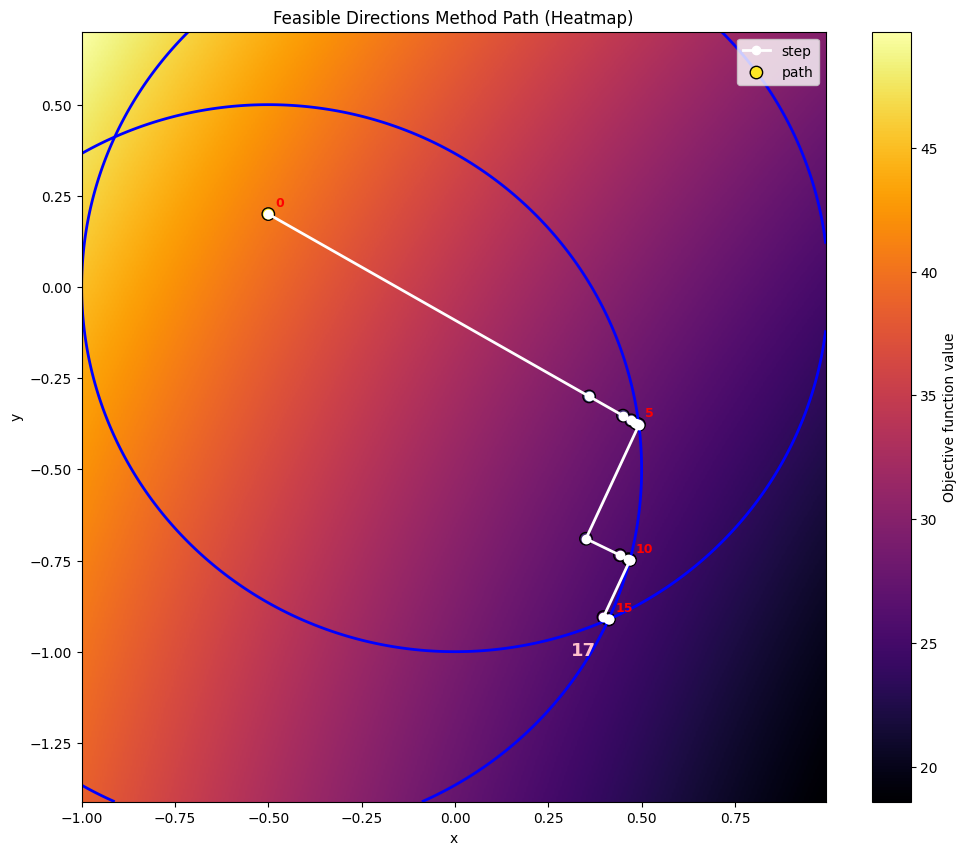

In [7]:
visualize()

In [8]:
# The testing was performed *manually*:

# Wolfram Alpha's answer is:
# f_val: 25.417
# point: [0.411438, -0.911438]
# My answer is:
print(results[0], results[1])

[ 0.41179988 -0.91142024] 25.41374569776003


In [9]:
# Correct

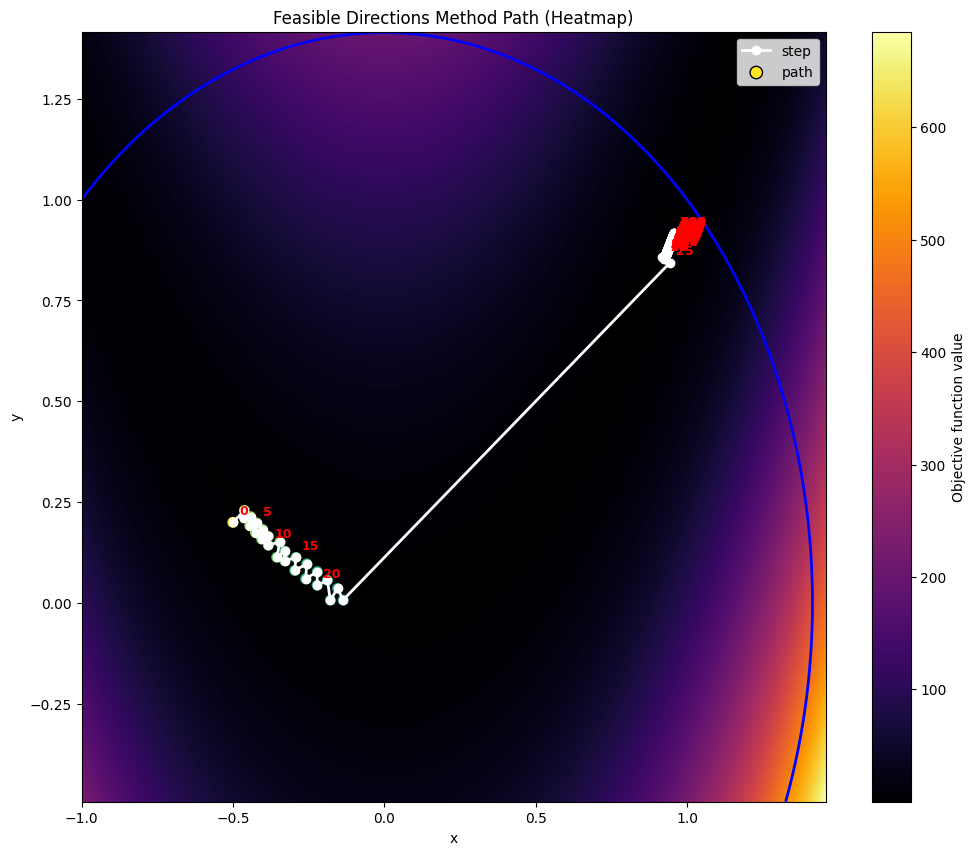

In [10]:
f = (1 - x)**2 + 100 * (y - x**2)**2
gs = [x**2 + y**2 - 2]

f_grad = sp.Matrix([sp.diff(f, var) for var in vars])
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

initial_point = [-0.5, 0.2]
step_size = 3
max_iter = 500

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [11]:
# The testing was performed *manually*:

# Wolfram Alpha's answer is:
# f_val: approx 0
# point: [approx 1, approx 1]
# My answer is:
print(results[0], results[1])

[0.95731319 0.91637873] 0.001822651380147231


In [12]:
# Imprecise. Let's see what the issue is:
history

[[array([-0.5,  0.2]), 2.5],
 [array([-0.46191406,  0.22929688]), 2.162576461185381],
 [array([-0.46203071,  0.21062624]), 2.138343857254262],
 [array([-0.4418155 ,  0.21396156]), 2.114028036992712],
 [array([-0.44434595,  0.19197646]), 2.0891238734521766],
 [array([-0.42172663,  0.19838294]), 2.0634530050687325],
 [array([-0.42535766,  0.17432483]), 2.0360061604492725],
 [array([-0.4020702 ,  0.18206426]), 2.007432397102634],
 [array([-0.40486726,  0.15815354]), 1.9769743493360181],
 [array([-0.38293451,  0.16490818]), 1.945884745026248],
 [array([-0.38312503,  0.14349879]), 1.9141146264748008],
 [array([-0.34480672,  0.15120034]), 1.912890121845284],
 [array([-0.35515722,  0.11333863]), 1.852830043832431],
 [array([-0.3286234 ,  0.12833631]), 1.8066237975975894],
 [array([-0.32872198,  0.10449689]), 1.7667703447702137],
 [array([-0.29209258,  0.11284357]), 1.7452685060853526],
 [array([-0.2957946 ,  0.08058713]), 1.6838547540955713],
 [array([-0.25584717,  0.09677615]), 1.67523618423

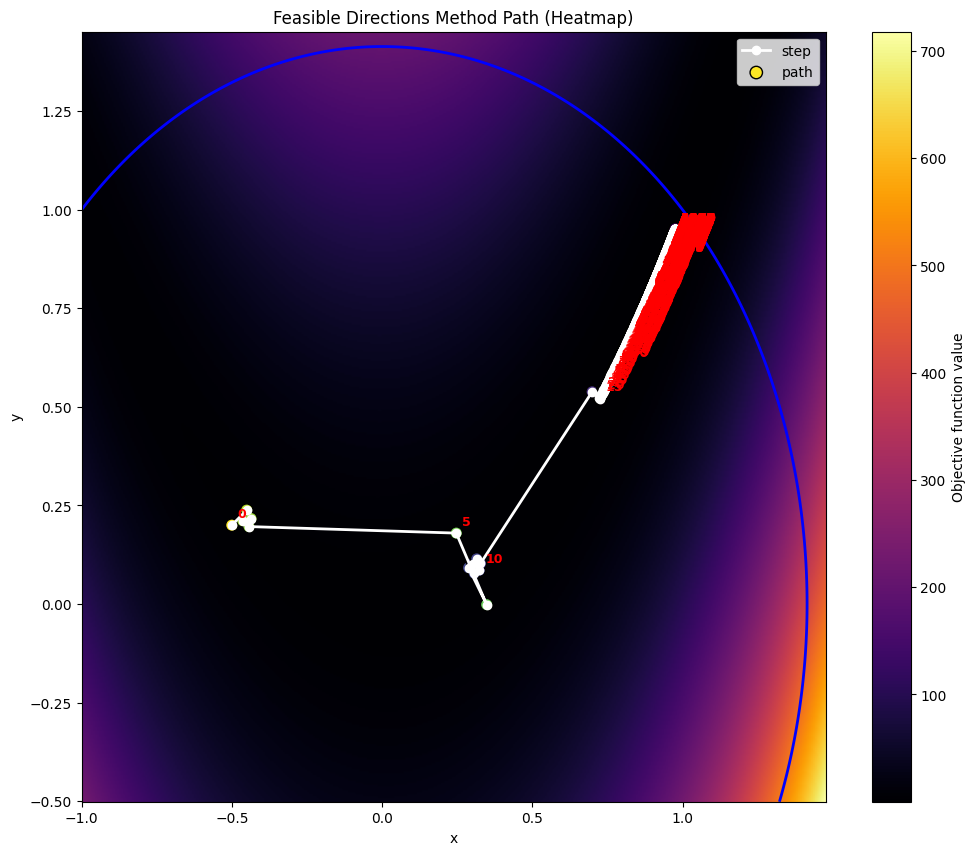

In [13]:
# The convergence is too slow. Let's increase the step_size

f = (1 - x)**2 + 100 * (y - x**2)**2
gs = [x**2 + y**2 - 2]

f_grad = sp.Matrix([sp.diff(f, var) for var in vars])
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

initial_point = [-0.5, 0.2]
step_size = 500
max_iter = 10000

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [14]:
# The specified function in 3D:

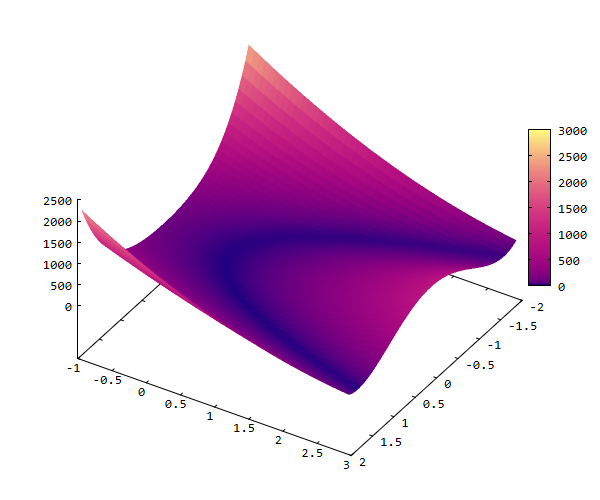

In [15]:
# The testing was performed *manually*:

# Wolfram Alpha's answer is:
# f_val: approx 0
# point: [approx 1, approx 1]
# My answer is:
print(results[0], results[1])

[0.97562075 0.95177776] 0.0005946851246000283


In [16]:
# The method slowly converges, although some techniques may be used to
# improve convergence (dynamic step_size), but
# that's out of the scope of this task

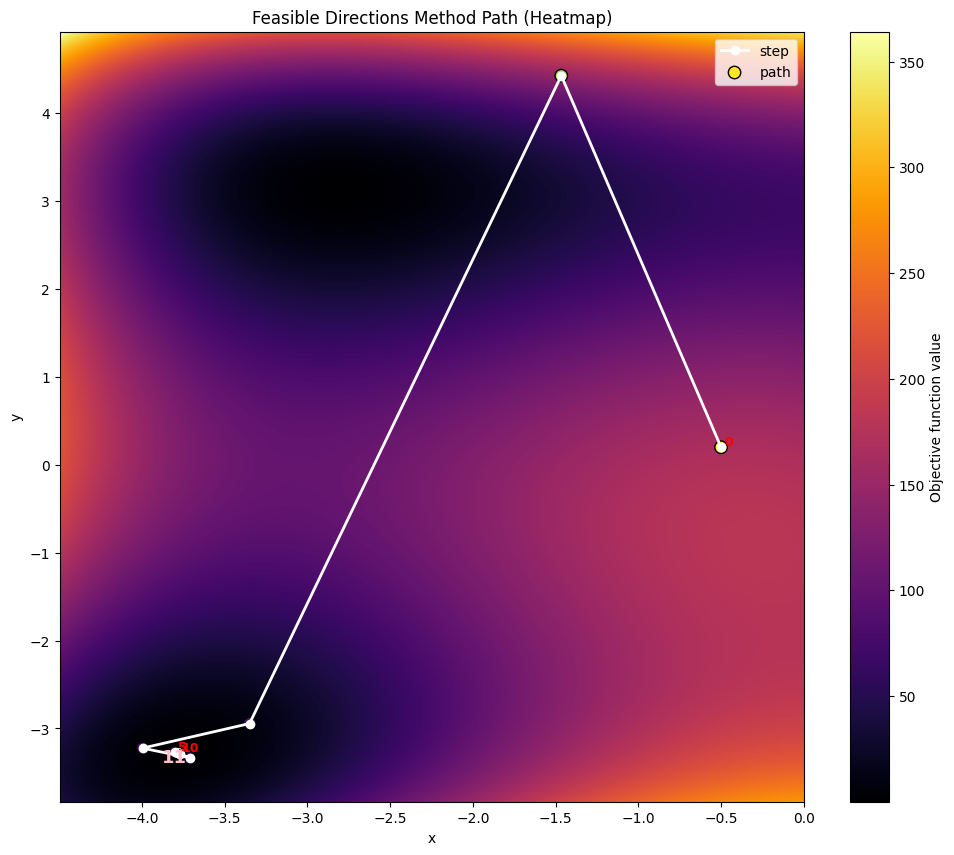

In [17]:
f = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
gs = []

f_grad = sp.Matrix([sp.diff(f, var) for var in vars])
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

initial_point = [-0.5, 0.2]
step_size = 10
max_iter = 100

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [18]:
# The specified function in 3D

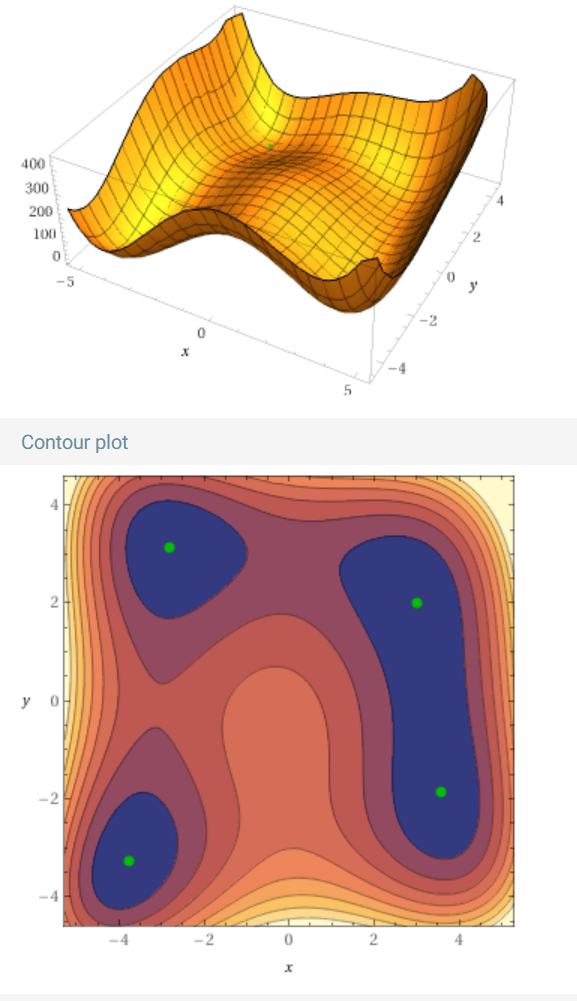

In [19]:
# The testing was performed *manually*:

# Wolfram Alpha's answer is:
# The function has 4 global minima.

# One of the minima is:
# f_val: 0
# point: [-3.77931, -3.28319]
# My answer is:
print(results[0], results[1])

[-3.77925242 -3.28322075] 3.0453793091792877e-07


In [20]:
# Correct

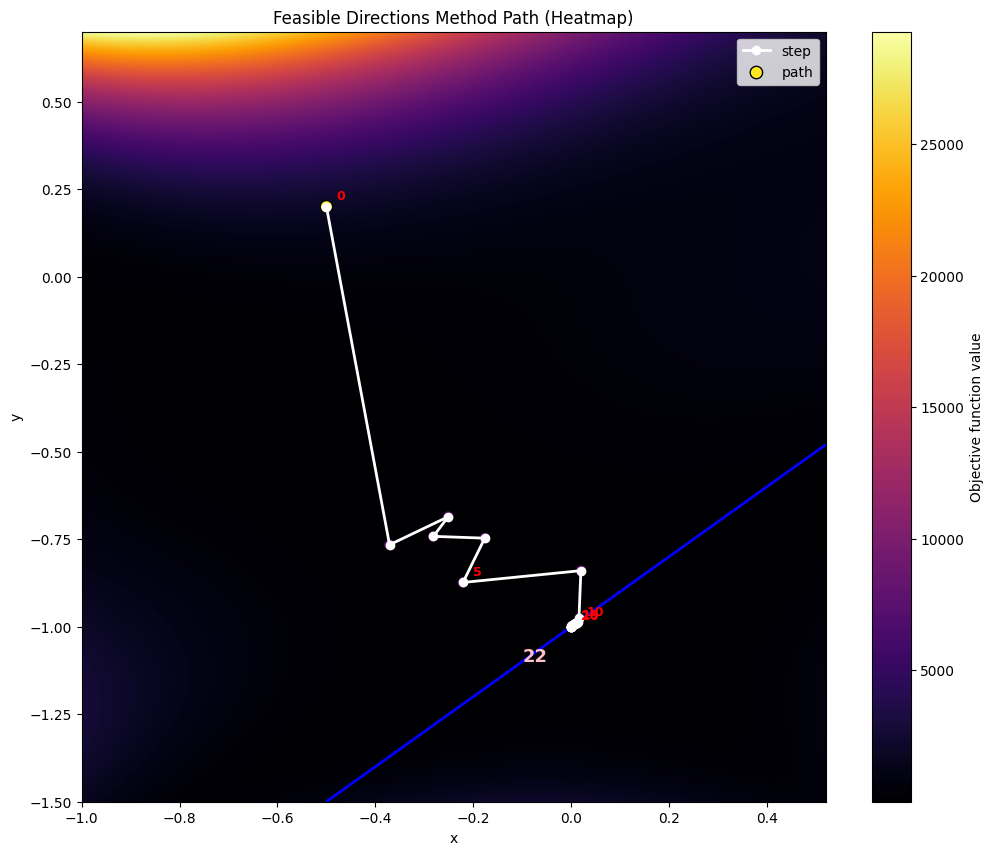

In [21]:
f = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
    (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
gs = [
    x**2 + y**2 - 5,         # circle
    x - y - 1                 # line
]

f_grad = sp.Matrix([sp.diff(f, var) for var in vars])
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

initial_point = [-0.5, 0.2]
step_size = 10
max_iter = 100

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

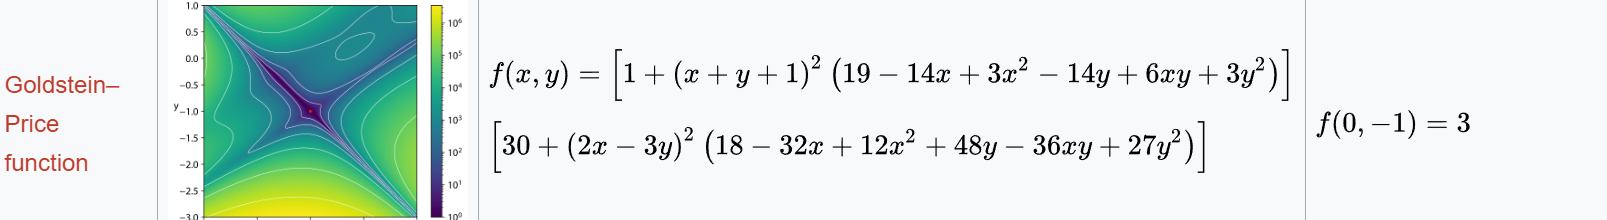

In [22]:
# The testing was performed *manually*:
# My answer is:
print(results[0], results[1])

[-3.59934523e-05 -9.99961724e-01] 3.000001256809666


In [23]:
# Correct

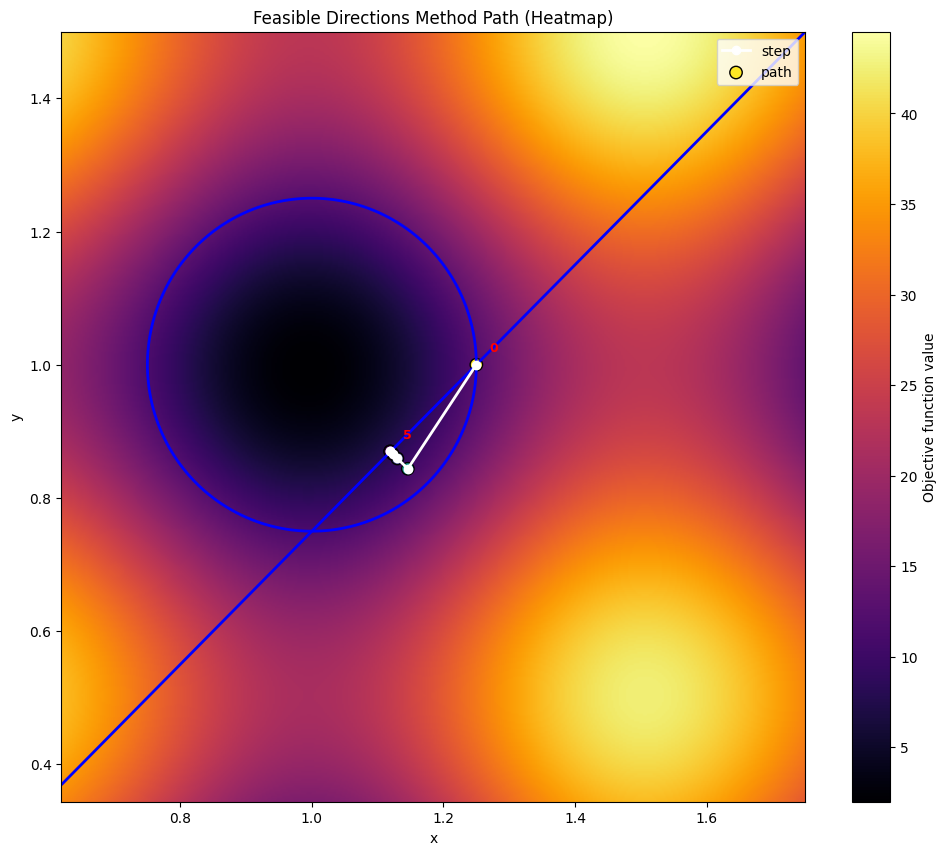

In [24]:
f = 20 + (x**2 - 10*sp.cos(2*sp.pi*x)) + (y**2 - 10*sp.cos(2*sp.pi*y))

# Constraints: circular feasible region with a bottleneck
gs = [
    (x - 1)**2 + (y - 1)**2 - 0.25**2, # tiny circle: x^2 + y^2 ≥ ? inside? let's pick ≤0.5 → allowed
    y - x + 0.25               # line: y - x ≤ 0.2
]

f_grad = sp.Matrix([sp.diff(f, var) for var in vars])
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

initial_point = [1.25, 1]
step_size = 10
max_iter = 100

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [25]:
# The testing was performed *manually*:

# Wolfram Alpha's answer is:
# f_val: 7.87488
# point: [1.11788, 0.867884]
# My answer is:
print(results[0], results[1])

[1.11908187 0.8697716 ] 7.844789225159463


In [26]:
# Correct

### Различные начальные приближения для одной и той же функции

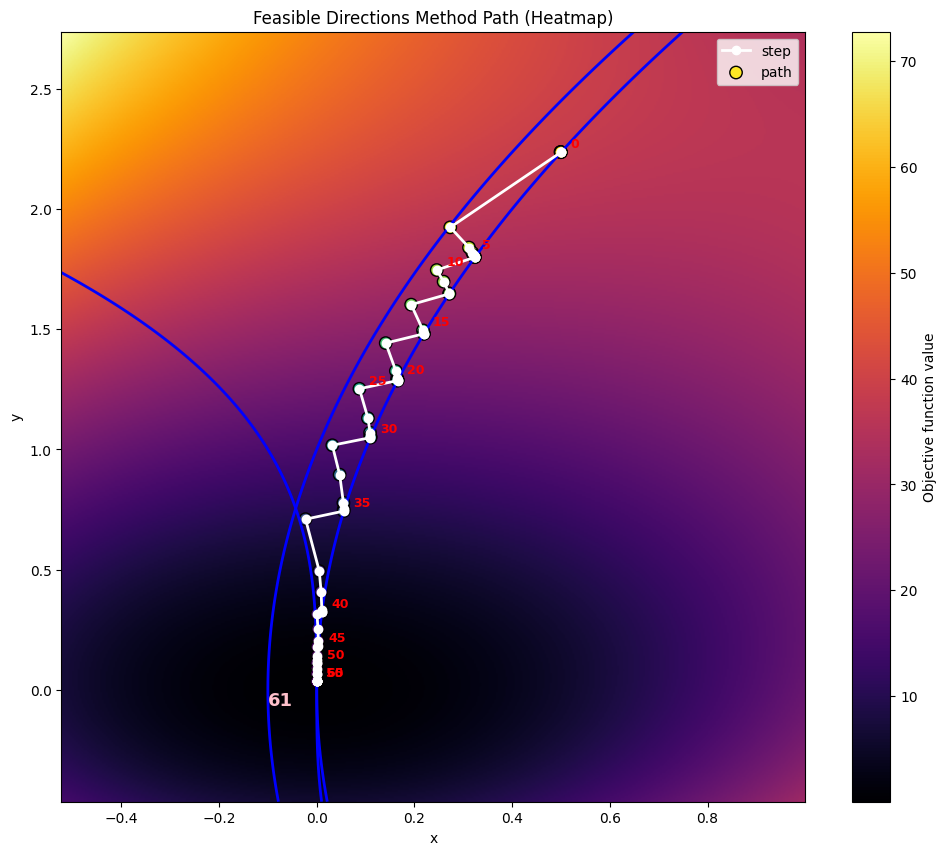

In [27]:
f = (x**2 + y**2)*((x - 2)**2 + (y - np.sqrt(20))**2)
# Constraints: circular feasible region with a bottleneck
gs = [
    10 * x - y**2,
    -10 * x - y**3,
    -10 * x - 1 + y**2,
]

f_grad = sp.Matrix([sp.diff(f, var) for var in vars])
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

initial_point = [0.5 - 0.001, np.sqrt(5) + 0.001]
step_size = 10
max_iter = 500

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [28]:
f_grad

Matrix([
[                 2*x*((x - 2)**2 + 20.0*(0.223606797749979*y - 1)**2) + (2*x - 4)*(x**2 + y**2)],
[2*y*((x - 2)**2 + 20.0*(0.223606797749979*y - 1)**2) + (x**2 + y**2)*(2.0*y - 8.94427190999916)]])

In [29]:
calculate(f_grad, [0, 0])

array([0., 0.])

In [30]:
calculate(f_grad, [2, np.sqrt(20)])

array([ 0.00000000e+00, -4.26325641e-14])

In [31]:
# The testing was performed *manually*:
print(results[0], results[1])

[7.11142115e-05 3.50766498e-02] 0.029144185601252055


In [32]:
# One of the minima is zero. Correct

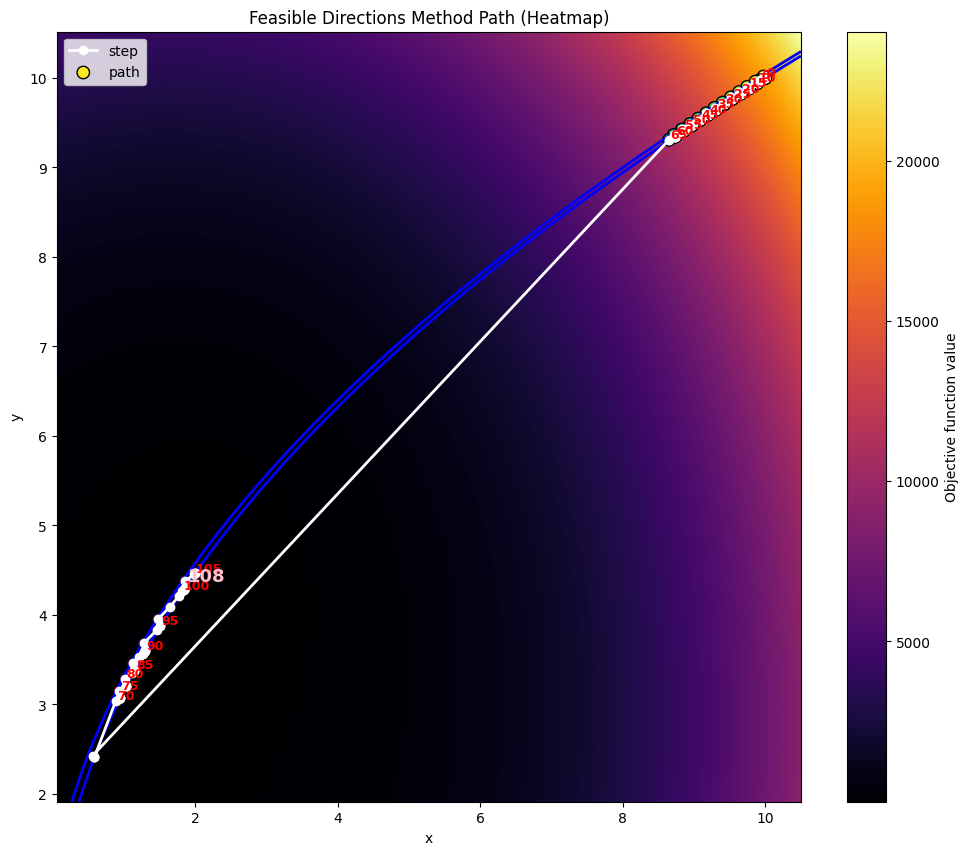

In [33]:
initial_point = [10 - 0.001, np.sqrt(100) + 0.001]

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [34]:
# The testing was performed *manually*:
print(results[0], results[1])

[1.99990799 4.47205232] 3.7103465377874933e-07


In [35]:
# One of the minima is (2, sqrt(20)). Correct

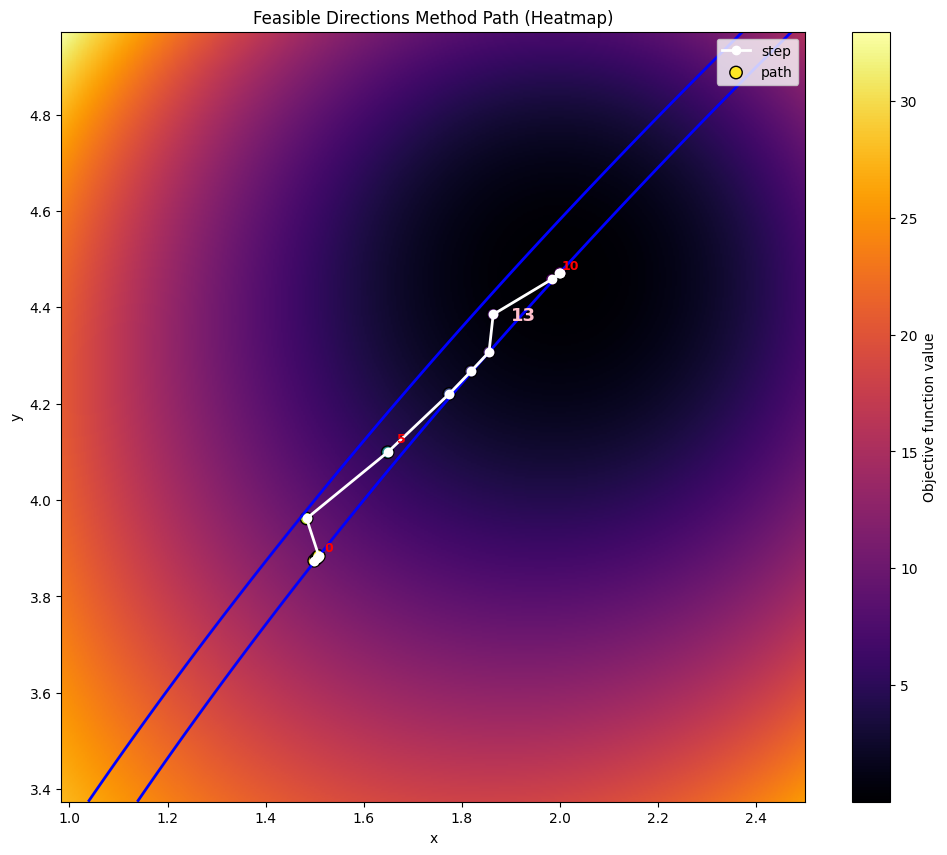

In [36]:
initial_point = [1.5 - 0.001, np.sqrt(15) + 0.001]

results = find_optimal(initial_point, record_history=True)
history = results[2]

visualize()

In [37]:
# The testing was performed *manually*:
print(results[0], results[1])

[1.99992077 4.47206674] 2.656118058173747e-07


In [38]:
# Correct

### Задачи высокой размерности

In [39]:
# Add symbols at your discretion
# Control the dimensionality of the problem
x, y, z, d, e, u, h = sp.symbols('x y z d e u h')
vars = [x, y, z, d, e, u, h]

# Specify the objective function
f = x**2 + y**2 + z**2 + d**2 + e**2 + u**2 + h**2

gs = [
    10 * x - y**2,
    -10 * x - y**3,
    -10 * x - 1 + y**2,
]

f_grad = sp.Matrix([sp.diff(f, var) for var in vars])
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

# Choose the initial point that is FEASIBLE (i.e. lies in P)
initial_point = [0.5 - 0.001, np.sqrt(5) + 0.001, 1, 2, 3, 4, 5]
step_size = 10
max_iter = 500

results = find_optimal(initial_point, record_history=True)
print(results[0], results[1])

[ 8.07356341e-05  2.01513004e-02 -2.88222078e-03 -3.24626406e-05
  5.28477144e-04 -4.36461978e-04  2.56588406e-03] 0.00042144322423362215


In [40]:
# Close to zero. Correct

In [41]:
# Add symbols at your discretion
# Control the dimensionality of the problem
x, y, z, d, e, u, h = sp.symbols('x y z d e u h')
vars = [x, y, z, d, e, u, h]

# Specify the objective function
f = x**2 + y**2 + z**2 + d**2 + e**2 + u**2 + h**2

gs = [
    10 * x - y**2,
    -10 * x - y**3,
    -10 * x - 1 + y**2,
    e**2 + u**2 + h**2 - 1
]

f_grad = sp.Matrix([sp.diff(f, var) for var in vars])
g_grads = [
    sp.Matrix([sp.diff(g, var) for var in vars]) for g in gs
]

# Choose the initial point that is FEASIBLE (i.e. lies in P)
initial_point = [0.5 - 0.001, np.sqrt(5) + 0.001, 0.1, 0.2, 0.3, 0.4, 0.5]
step_size = 10

# Increased number of iterations
max_iter = 2000

results = find_optimal(initial_point, record_history=True)
print(results[0], results[1])

[ 9.88647721e-05  2.22645306e-02 -2.92338783e-05 -9.58145294e-05
  1.11468907e-04 -1.27249334e-05  3.35505103e-05] 0.0004957428467469591


In [42]:
# Close to zero. Correct